In [240]:
from music21 import *

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import random

In [241]:
# get bach paths
paths = corpus.getComposer('bach')

# get n pieces
#paths = paths[:10]

# get all the notes of the first part of each piece
notes = []
midi_notes = []
for path in paths:
    score = converter.parse(paths[0])

    for part in score.parts:
        # get all notes from the part
        notes.extend(list(map(lambda note: note, part.recurse().notes)))

# midi_notes = list(map(lambda note: note.pitch.midi if note.pitch else None, notes))
midi_notes = []
for n in notes:
    # handle chords -> get hightest ptch
    if isinstance(n, chord.Chord):
        midi_notes.append(n.pitches[-1].midi)
    else:
        midi_notes.append(n.pitch.midi)

print(f'len(notes): {len(notes)}')
print(f'len(midi_notes): {len(midi_notes)}')
# print(midi_notes)

len(notes): 215634
len(midi_notes): 215634


In [242]:
# turn notes in to training sequences of 5
# map each sequence to note that follows
# [65, 67, 60, 65, 53] -> 57
# [67, 60, 65, 53, 57] -> 53

# set the length of the sequence that predicts the next note
seq_length = 7

data = []
labels = []
for i in range(len(midi_notes)):
    seq_end = i + seq_length
    
    if seq_end >= len(midi_notes): break
    
#     print(f'i: {i}')
#     print(f'seq_end: {seq_end}')
    
    seq = midi_notes[i:seq_end]        
    data.append(seq)
    labels.append(midi_notes[seq_end])

print(f'data:\n{data[:3]}')
print(f'labels:\n{labels[:3]}')

data:
[[65, 67, 60, 65, 53, 57, 53], [67, 60, 65, 53, 57, 53, 57], [60, 65, 53, 57, 53, 57, 60]]
labels:
[57, 60, 65]


In [243]:
# get the data in shape
data = np.array(data, dtype=float)
data = data.reshape(-1, seq_length, 1)

labels = np.array(labels, dtype=float)
labels = labels.reshape(-1, 1)

In [244]:
# normalize
from sklearn.preprocessing import MinMaxScaler

# print(f'data.shape: {data.shape}')
# print(f'labels.shape: {labels.shape}')

data_flat = data.reshape(-1, 1)
# print(f'data_flat.shape: {data_flat.shape}')

# print(f'data[0]: {data[0]}')
# print(f'data_flat[0]: {data[0]}')

# scale data
scaler_data = MinMaxScaler(feature_range=(0, 1))
scaler_data = scaler_data.fit(data_flat)
data_norm = scaler_data.transform(data_flat)

# scale labels
scaler_labels = MinMaxScaler(feature_range=(0, 1))
scaler_labels = scaler_labels.fit(labels)
labels_norm = scaler_labels.transform(labels)

# reshape
data_norm = data_norm.reshape(-1, seq_length, 1)
labels_norm = labels_norm.reshape(-1, 1)

print(f'min(data): {min(data.reshape(-1, 1))}')
print(f'max(data): {max(data.reshape(-1, 1))}')

print(f'min(labels): {min(labels)}')
print(f'max(labels): {max(labels)}')

print('{seq} -> {labels[i]}')
for i, seq in enumerate(data):
    print(f'{seq} -> {labels[i]}')
    break
    
print('{seq} -> {labels_norm[i]}')
for i, seq in enumerate(data_norm):
    print(f'{seq} -> {labels_norm[i]}')
    break


min(data): [41.]
max(data): [77.]
min(labels): [41.]
max(labels): [77.]
{seq} -> {labels[i]}
[[65.]
 [67.]
 [60.]
 [65.]
 [53.]
 [57.]
 [53.]] -> [57.]
{seq} -> {labels_norm[i]}
[[0.66666667]
 [0.72222222]
 [0.52777778]
 [0.66666667]
 [0.33333333]
 [0.44444444]
 [0.33333333]] -> [0.44444444]


In [245]:
# get test and train data

x_train, x_test, y_train, y_test = train_test_split(data_norm, labels_norm, test_size=0.2, random_state=4)

In [246]:
# build the model

model = Sequential()
# model.add(LSTM((512), batch_input_shape=(None, seq_length, 1), activation='relu', return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM((256), activation='relu', batch_input_shape=(None, seq_length, 1), return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM((128), activation='relu', batch_input_shape=(None, seq_length, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM((64), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
# model.add(LSTM((32), activation='relu', return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM((1), activation='relu', return_sequences=False))
# model.add(Dense(1, activation='relu'))


In [247]:
# compile the model

model.compile(loss='mse', optimizer='adam')
print(model.input_shape)
print(model.output_shape)
print(model.summary())

(None, 7, 1)
(None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 7, 128)            66560     
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 7, 64)             49408     
_________________________________________________________________
dropout_28 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 1)                 264       
Total params: 116,232
Trainable params: 116,232
Non-trainable params: 0
_________________________________________________________________
None


In [248]:
# checkpoint

filepath="weights-improvement-{epoch:02d}-{val_loss:.10f}.hdf5"
checkpoint = EarlyStopping(monitor='val_loss', mode='auto', patience=2, verbose=1, restore_best_weights=True )
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

callbacks_list = [checkpoint]

In [249]:
# fit the model

history = model.fit(x_train, y_train, epochs=1000, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks_list)

Train on 172501 samples, validate on 43126 samples
Epoch 1/1000
172501/172501 [==============================] - 74s 429us/step - loss: 0.0174 - val_loss: 0.0082
Epoch 2/1000
172501/172501 [==============================] - 67s 388us/step - loss: 0.0087 - val_loss: 0.0063
Epoch 3/1000
172501/172501 [==============================] - 66s 382us/step - loss: 0.0064 - val_loss: 0.0041
Epoch 4/1000
172501/172501 [==============================] - 65s 379us/step - loss: 0.0047 - val_loss: 0.0039
Epoch 5/1000
172501/172501 [==============================] - 65s 379us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 6/1000
172501/172501 [==============================] - 65s 378us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 7/1000
172501/172501 [==============================] - 66s 381us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/1000
172501/172501 [==============================] - 66s 383us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 9/1000
172501/172501 [==============================] -

In [250]:
# get the score

score = model.evaluate(x_test, y_test, batch_size=64)
print(score)

43126/43126 [==============================] - 4s 97us/step
0.0010966080523394516


In [251]:
# save model
model.save('model.h5')

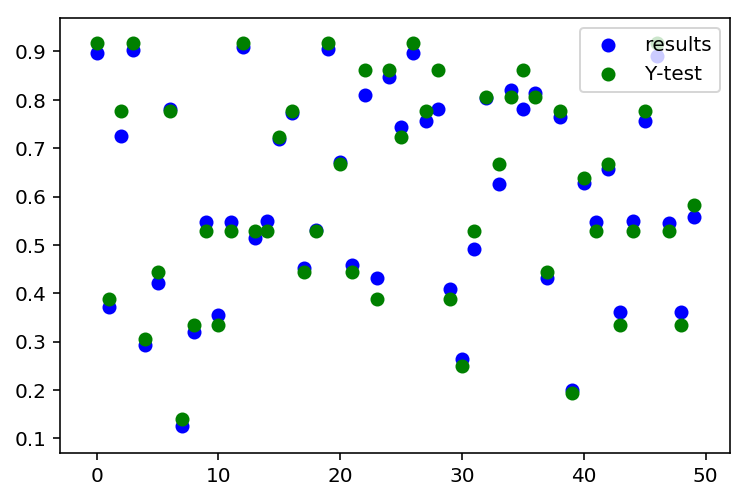

In [252]:
# predict y_test

results= model.predict(x_test)
plt.scatter(range(50), results[:50], c='b')
plt.scatter(range(50), y_test[:50], c='g')
plt.legend(['results', 'Y-test'], loc='upper right')

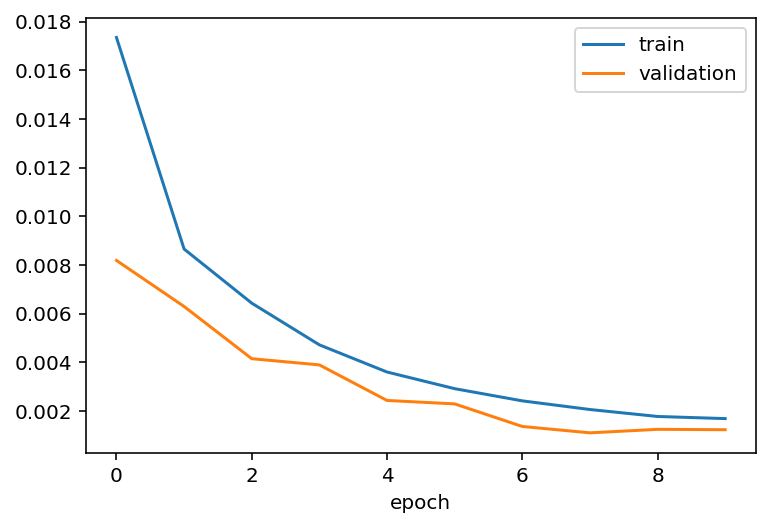

In [253]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [254]:
# load best weights

# model.load_weights('weights-improvement-57-0.0000455168.hdf5')

# score = model.evaluate(x_test, y_test, batch_size=64)
# print(score)

In [269]:
# create original melody

max_note = max(midi_notes)
min_note = min(midi_notes)
print(f'min_note: {min_note}')
print(f'max_note: {max_note}')

# create a random start sequence (normalize)
# seed_seq = np.array([random.randrange(min_note, max_note) for _ in range(seq_length)])
# print(f'seed_seq: {seed_seq}')
# seed_seq = scaler_data.transform(seed_seq.reshape(-1, 1))
# seed_seq = seed_seq.reshape(-1, seq_length, 1)

# get a seq_length long sequence from the training data as a seed
seed_seq = data[random.randrange(1, len(data) - seq_length)]
seed_seq = scaler_data.transform(seed_seq.reshape(-1, 1))
seed_seq = seed_seq.reshape(-1, seq_length, 1)
print(f'seed_seq: {seed_seq}')

# holds sequence for next prediction
cur_seq = seed_seq.copy()

# melody starts with our random start sequence
melody = cur_seq.copy()

# melody is 500 notes long
melody_length = 500

# cur_seq moves along with the end of the melody to determine the next note
for _ in range(melody_length):
    next_note = model.predict(cur_seq)
#     print(f'next_note: {next_note}')
    melody = np.append(melody, next_note)
    cur_seq = np.append(cur_seq[0][1:], next_note).reshape(1, seq_length, 1)
#     print(f'cur_seq: {cur_seq}')

# print(f'melody: {melody}')



min_note: 41
max_note: 77
seed_seq: [[[0.66666667]
  [0.72222222]
  [0.66666667]
  [0.58333333]
  [0.63888889]
  [0.66666667]
  [0.63888889]]]


In [256]:
def to_midi_file(flat_midi_notes, path):
    s = stream.Stream()
    
    for midi_note in flat_midi_notes:
        #print(midi_note)
        p = pitch.Pitch()
        p.midi = round(midi_note)
        n = note.Note()
        n.pitch = p
        s.append(n)
    
    fp = s.write('midi', fp=path)
    return (s, fp)

In [271]:
# turn melody into a midi file

# print(melody[0])

# denormalize
melody_denorm = scaler_labels.inverse_transform(melody.reshape(-1, 1)).reshape(-1)
# print(melody_denorm)
# print(melody_denorm[0])

# write source melody to file
s, fp = to_midi_file(midi_notes[:500], 'source.midi')

# write new melody to file
s, fp = to_midi_file(melody_denorm, 'machine_bach.midi')
# s.show('text')
